# Scanning Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()

from adamacs.pipeline import subject, session, surgery, scan, equipment
from adamacs import utility
from adamacs.ingest import session as isess
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())

[2023-02-27 21:40:26,902][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-02-27 21:40:26,961][INFO]: Connected tobiasr@172.26.128.53:3306


In [2]:
# subject.Subject.drop()
# subject.Mutation.drop()
# subject.Protocol.drop()
# subject.Line.drop()
# subject.SubjectGenotype.drop()
# equipment.Equipment.drop()
# scan.Scan.drop()
# session.Session.drop()
# imaging.Processing.drop()

In [3]:
# session.Session.delete()

In [4]:
scan.Scan.describe()

'-> session.Session\nscan_id              : varchar(12)                  \n---\n-> [nullable] equipment.Equipment\n-> scan.AcquisitionSoftware\nscan_notes=""        : varchar(4095)                # free-notes\n'

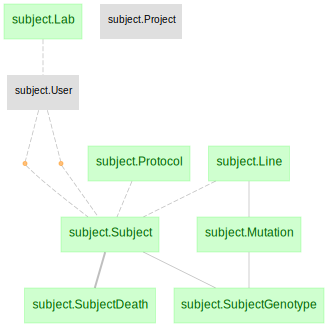

In [5]:
dj.Diagram(subject) + dj.Diagram(protocol)

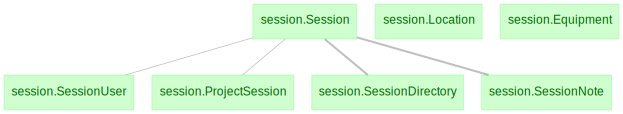

In [6]:
dj.Diagram(session) 

In [7]:
session.SessionDirectory()

session_id,session_dir Path to the data directory for a session,user_id
sess9FGLEFJ3,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLEFJ3_sess9FGLEFJ3,7
sess9FGLZLRI,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI,7


In [8]:
session.SessionUser()

session_id,user_id
sess9FGLEFJ3,7
sess9FGLZLRI,7


In [9]:
session.SessionNote()

session_id,session_note
sess9FGLEFJ3,Awesome session


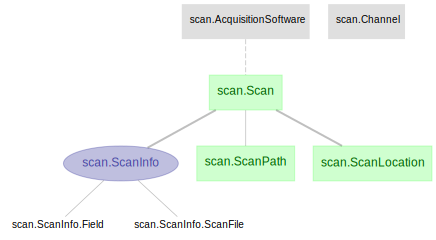

In [10]:
dj.Diagram(scan) 

In [11]:
scan.ScanInfo.ScanFile()

session_id,scan_id,file_path filepath relative to root data directory


In [12]:
scan.ScanInfo.Field()

session_id,scan_id,field_idx,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans


In [13]:
scan.ScanPath()

session_id,scan_id,user_id,path


In [14]:
scan.ScanLocation()

session_id,scan_id,anatomical_location


In [15]:
scan.AcquisitionSoftware()

acq_software
NIS
Scanbox
ScanImage


In [16]:
scan.Channel()

channel 0-based indexing
0
1
2
3
4


Manual entry:

In [17]:
# Manual Entry
import datajoint as dj; import getpass
dj.config['database.host'] = '172.26.128.53'        # Put the server name between these apostrophe
dj.config['database.user'] = 'danielmk'             # Put your user name between these apostrophe
dj.config['database.password'] = getpass.getpass()  # Put your password in the prompt
dj.conn()

from adamacs.pipeline import subject, session, surgery, scan, equipment
from adamacs import utility
from adamacs.ingest import session as isess
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())


## Ingesting scan

Ingest all scans associated with a given session ID.

In [19]:
# isess.ingest_session_scan('sess9FB2LN5C', verbose=True)
isess.ingest_session_scan('sess9FGLZLRI', verbose=False) #TR: needs to be SessioID ("sess...")

In [ ]:
session.Session()

In [ ]:
session.SessionNote()

In [ ]:
session.SessionDirectory() * session.ProjectSession() * sub

In [ ]:
session.ProjectSession()

In [ ]:
key='scan9FG1UAQG'
(scan.Scan & f'scan_id=\"{key}\"')

Simple user look-up to get user_id from shorthand

In [ ]:
key='RN'
query = (subject.User & f'initials=\"{key}\"')
id = query.fetch("user_id")[0]
print(key + ' = ' + str(id))

In [ ]:
key='%Tob%'
query = (subject.User & f'name LIKE \"{key}\"')
id = query.fetch("user_id")
print(key + ' = ' + str(id))

In [ ]:
key='%Ji%'
query = (subject.User & f'name LIKE \"{key}\"')
query.fetch("email")

In [ ]:
query = subject.Subject() & '"ROS-1380"'
query.fetch()

In [ ]:
subject.Subject() & "subject = 'ROS-1346'"